### 传统的格兰杰因果检验只能检验线性因果关系，这里使用了动态传递熵，用以衡量两个序列直接动态的非线性因果关系

In [1]:
import pandas as pd
import numpy as np
%matplotlib notebook
from sklearn import preprocessing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA 
import statsmodels.tsa.stattools as st
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as stats
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
import statsmodels.api as sm
import os
import matplotlib.pyplot as plt
from PyCausality.TransferEntropy import *
from PyCausality.Testing.Test_Utils.Time_Series_Generate import *

### 美国EPU与美国进出口之间的关系

In [3]:
data = pd.read_excel("C:Desktop/贸易数据.xlsx", index_col=0)

In [4]:
data.index = pd.to_datetime(data.index)

In [5]:
data = data['2005':]

<IPython.core.display.Javascript object>


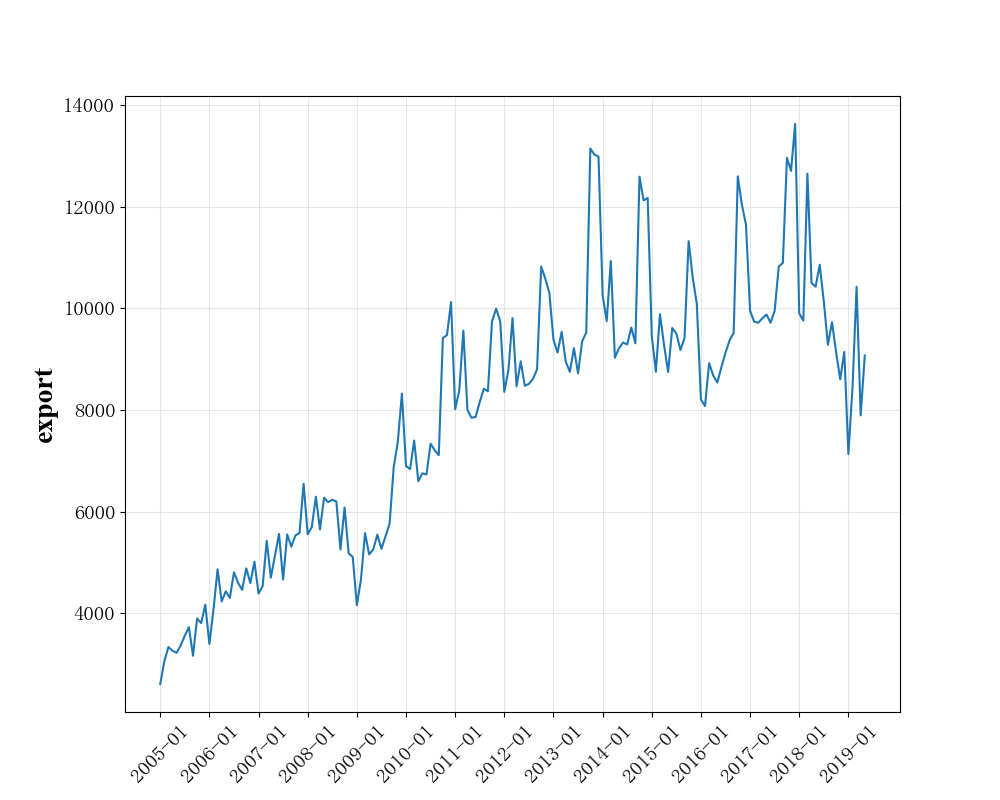

In [6]:
%matplotlib notebook
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 20,
}
fig = plt.figure(figsize=(10,8))
plt.plot([str(i)[:7] for i in data.index], data.ex.values)
plt.ylabel('export',font1)
# plt.xlabel('t',font1)
plt.tick_params(labelsize=15)
# plt.legend(loc=1,prop=font1)
plt.grid(alpha=0.3)
plt.xticks([str(i)[:7] for i in data.index][::12], rotation=45)
plt.savefig('C:Desktop/ex.png',dpi=600)

<IPython.core.display.Javascript object>


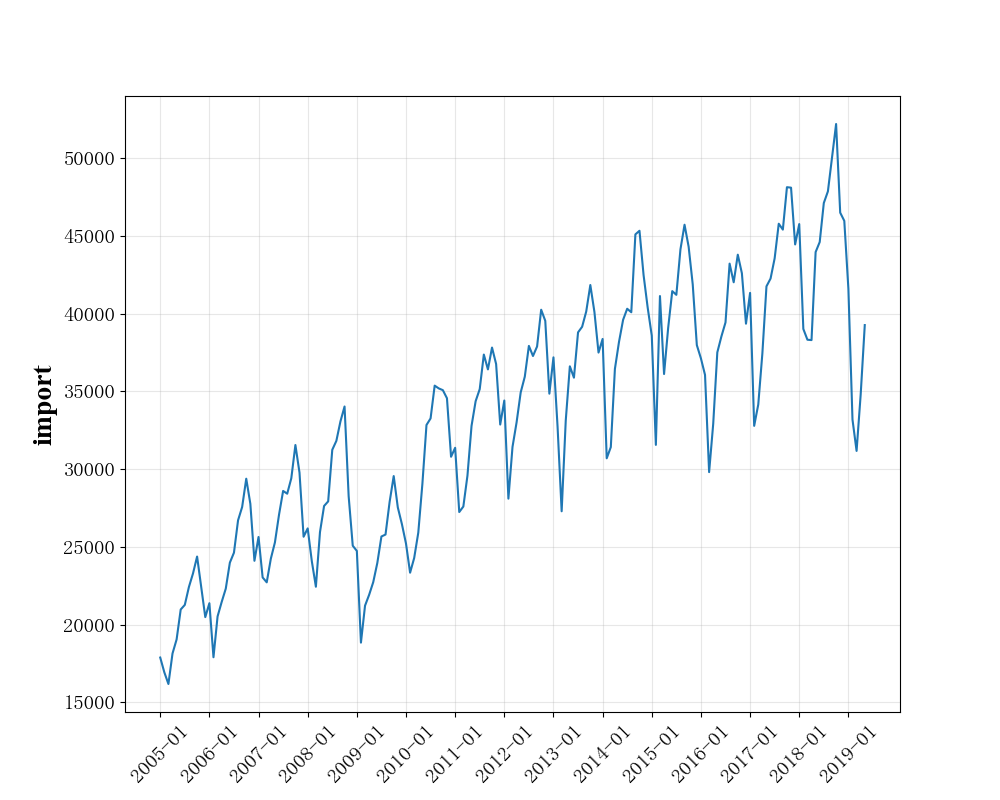

In [91]:
%matplotlib notebook
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 20,
}
fig = plt.figure(figsize=(10,8))
plt.plot([str(i)[:7] for i in data.index], data.im.values)
plt.ylabel('import',font1)
# plt.xlabel('t',font1)
plt.tick_params(labelsize=15)
# plt.legend(loc=1,prop=font1)
plt.grid(alpha=0.3)
plt.xticks([str(i)[:7] for i in data.index][::12], rotation=45)
plt.savefig('C:Desktop/im.png',dpi=600)

<IPython.core.display.Javascript object>


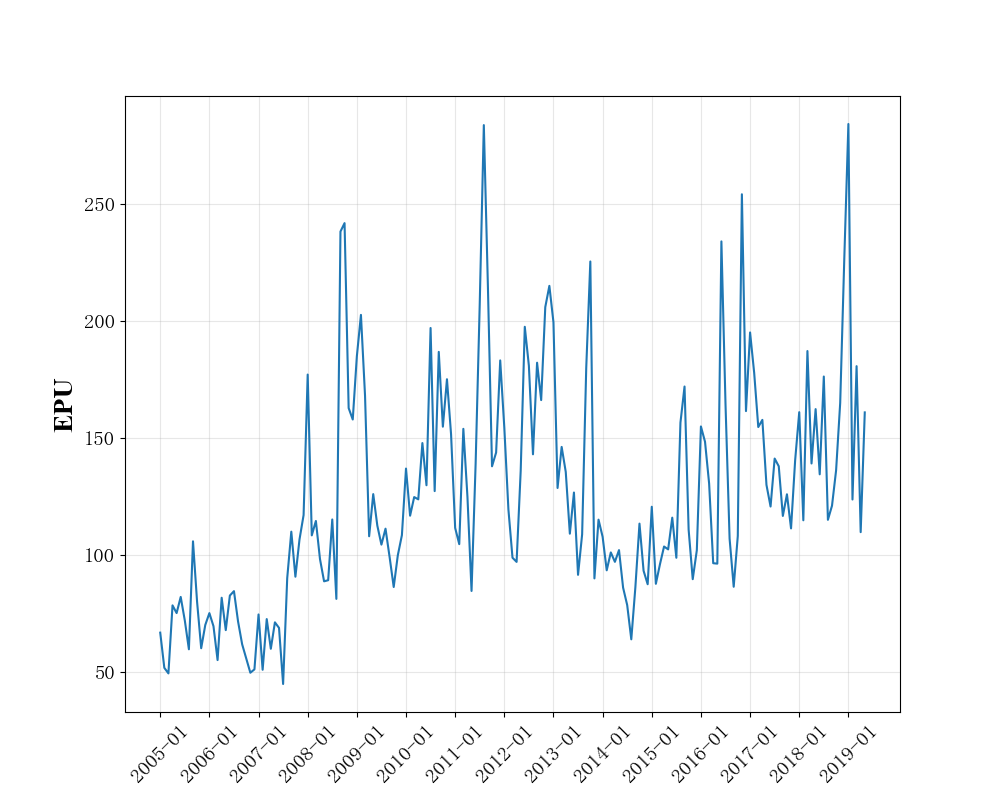

In [92]:
%matplotlib notebook
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 20,
}
fig = plt.figure(figsize=(10,8))
plt.plot([str(i)[:7] for i in data.index], data.News_Based_Policy_Uncert_Index.values)
plt.ylabel('EPU',font1)
# plt.xlabel('t',font1)
plt.tick_params(labelsize=15)
# plt.legend(loc=1,prop=font1)
plt.grid(alpha=0.3)
plt.xticks([str(i)[:7] for i in data.index][::12], rotation=45)
plt.savefig('C:Desktop/epu.png',dpi=600)

In [6]:
data.head(2)

,News_Based_Policy_Uncert_Index,ex,im,ba
2005-01-01,66.734337,2609.3,17885.8,-15276.5
2005-02-01,51.695686,3058.1,16937.6,-13879.5


In [8]:
data.describe().to_excel("C:Desktop/statas.xlsx")

In [10]:
from scipy import stats #scipy中的stats可以做统计推断

In [7]:
epu = data.News_Based_Policy_Uncert_Index.values
ex = data.ex.values
im = data.im.values

In [14]:
cny = data.cny.values

In [26]:
print('epu-----JB：%f,       p-values:%f'%(stats.jarque_bera(epu)[0],stats.jarque_bera(epu)[1]))
print('im------JB：%f,        p-values:%f'%(stats.jarque_bera(im)[0],stats.jarque_bera(im)[1]))
print('ex------JB：%f,        p-values:%f'%(stats.jarque_bera(ex)[0],stats.jarque_bera(ex)[1]))
print('cny-----JB：%f,       p-values:%f'%(stats.jarque_bera(cny[3:])[0],stats.jarque_bera(cny[3:])[1]))

epu-----JB：21.837055,       p-values:0.000018
im------JB：5.726780,        p-values:0.057075
ex------JB：4.946024,        p-values:0.084330
cny-----JB：28.191009,       p-values:0.000001


### 去除季节效应

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data.im)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [7]:
data['im'] = trend

In [13]:
data_ = pd.read_excel('C:Desktop/优化建模/传递熵/cny and usd exchange rate.xlsx')
data_ = data_[::-1]
data_.index = data_['Date']
data_ = data_['2005':]
data['cny'] = data_['CNY']

<IPython.core.display.Javascript object>


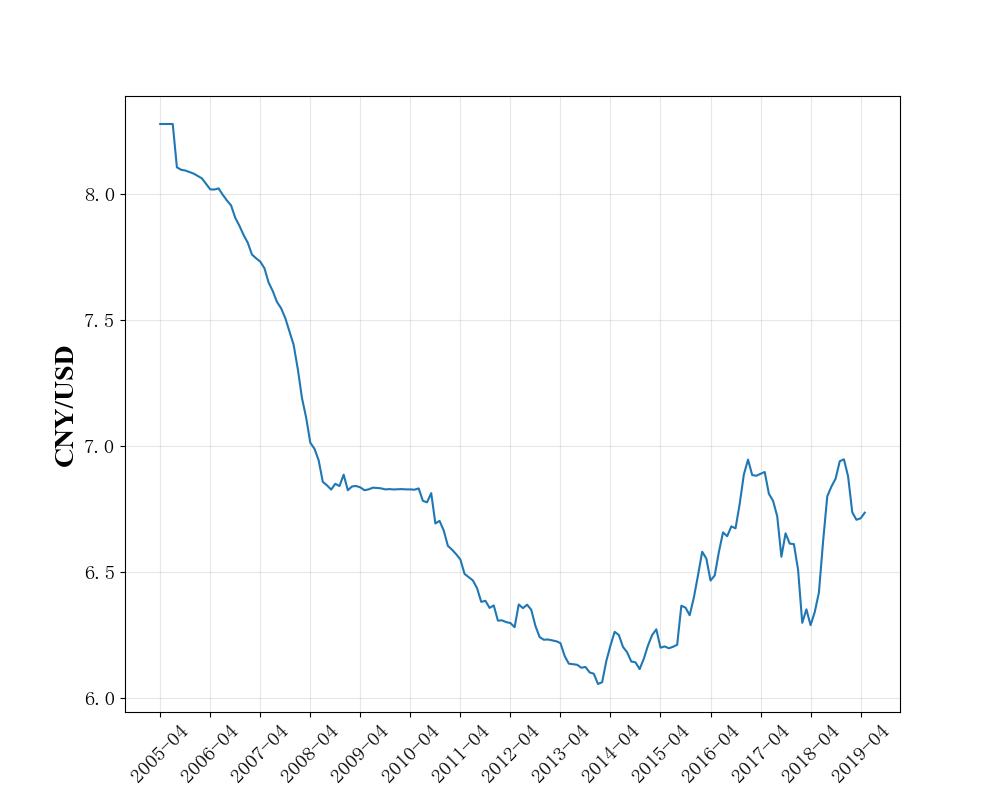

In [94]:
%matplotlib notebook
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 20,
}
fig = plt.figure(figsize=(10,8))
plt.plot([str(i)[:7] for i in data.index][3:], data.News_Based_Policy_Uncert_Index.values[3:])
plt.ylabel('CNY/USD',font1)
# plt.xlabel('t',font1)
plt.tick_params(labelsize=15)
# plt.legend(loc=1,prop=font1)
plt.grid(alpha=0.3)
plt.xticks([str(i)[:7] for i in data.index][3:][::12], rotation=45)
plt.savefig('C:Desktop/CNY.png',dpi=600)

In [41]:
epu = data.News_Based_Policy_Uncert_Index.values[3:]

In [42]:
stats.skew(epu) #求偏度

0.9971541812787784

In [43]:
stats.kurtosis(epu) #求峰度

-0.051393665799058574

# 传递熵

In [10]:
data1 = data[['im', 'News_Based_Policy_Uncert_Index']]

In [11]:
data1[['im', 'News_Based_Policy_Uncert_Index']].describe()

,im,News_Based_Policy_Uncert_Index
count,161.000000,173.000000
mean,33548.292805,6.692288
std,6877.373847,1.076551
min,20434.879167,0.000000
25%,26947.983333,6.305600
50%,34807.116667,6.701500
75%,39163.841667,6.888200
max,44913.604167,8.276500


In [12]:
data1.columns = ['S2', 'S1']

In [13]:
walk = data1.copy()
walk.index = range(len(walk))
walk.describe()

,S2,S1
count,161.000000,173.000000
mean,33548.292805,6.692288
std,6877.373847,1.076551
min,20434.879167,0.000000
25%,26947.983333,6.305600
50%,34807.116667,6.701500
75%,39163.841667,6.888200
max,44913.604167,8.276500


In [14]:
walk.dropna(inplace=True)
walk =  np.log(walk).diff().iloc[1:]
walk.index = range(len(walk))

In [16]:
BIN1 = walk.describe(percentiles=[0,0.1, 0.2, 0.3, 0.4,0.5, 0.6,0.7, 0.8,0.9,1])[4:-1].S1.values.tolist()
BIN2 = walk.describe(percentiles=[0,0.1, 0.2, 0.3, 0.4,0.5, 0.6,0.7, 0.8,0.9,1])[4:-1].S2.values.tolist()

In [18]:
## Set Parameters
# DATALAG = 1,3,6#3                     # The TE code should pick out this lag, which contributes most information
LAGs = [r for r in range(1,10,1)]
SIMILARITY = 0.5                # Choose value between 0 (independent) to 1 (exact lagged value)
AUTOSIMILARITY = 0.3            # Choose value between 0 (independent) to 1 (exact lagged value)
SEED = None                     # Change pseudo-RNG seed; useful for repeat results & comparing bin choices

MAX_BINS = 10
N_SHUFFLES = 50
DATA_POINTS = 500

In [19]:
def TE(data, LAGs):
    
    ## Create Lists for Results
    lTEs_XY = []
    lTEs_YX = []
    TEs_XY = []
    TEs_YX = []
    z_scoresXY = []
    z_scoresYX = []
    ##------------------------------ Compare TE at Different Lags ------------------------------##
    for LAG in LAGs:
        print('LAG', LAG)

        ## Create Lagged Time Series
        DF = LaggedTimeSeries(data,LAG).df

        ## Initialise TE object
        linear_causality = TransferEntropy(DF = DF,
                                    endog = 'S2',          # Dependent Variable
                                    exog = 'S1',           # Independent Variable
                                    lag = LAG,
                        )
        causality = TransferEntropy(DF = DF,
                                    endog = 'S2',          # Dependent Variable
                                    exog = 'S1',           # Independent Variable
                                    lag = LAG)

        ## Define Bins
        bins = {    'S1':BIN1,
                    'S1_lag'+str(LAG):BIN1,
                    'S2':BIN2,
                    'S2_lag'+str(LAG):BIN2,
                    } 

        auto = AutoBins(walk,LAG)
        bins = auto.equiprobable_bins(10)

        (lTE_XY, lTE_YX) = linear_causality.linear_TE()
        (TE_XY, TE_YX) = causality.nonlinear_TE(  pdf_estimator = 'histogram’',
                                                  bins = bins,
                                                  n_shuffles = N_SHUFFLES)


        ## Store Results
        TEs_XY.append(TE_XY)
        TEs_YX.append(TE_YX)
        lTEs_XY.append(lTE_XY)
        lTEs_YX.append(lTE_YX)
        z_scoresXY.append(causality.results['z_score_XY'].iloc[0])
        z_scoresYX.append(causality.results['z_score_YX'].iloc[0])

    results = pd.DataFrame({'lTE_XY':lTEs_XY,
                            'lTE_YX':lTE_YX,
                            'TE_XY':TEs_XY,
                            'TE_YX':TEs_YX,
                            'Z_XY':z_scoresXY,
                            'Z_YX':z_scoresYX} )
    results['lags'] = LAGs
    return results

In [1]:
Windows = 12 * 3
Max_lag_XY = []
Max_zcore_XY = []
Max_TE_XY = []
Max_lag_YX = []
Max_zcore_YX = []
Max_TE_YX = []
for i in range(Windows,len(walk)):
    data_temp = walk.iloc[i-Windows:i,:]
    res = TE(data_temp, range(1,8))
    Max_lag_XY.append(res.sort_values(by=['Z_XY'],ascending=False)['lags'].values[0])
    Max_TE_XY.append(res.sort_values(by=['Z_XY'],ascending=False)['TE_XY'].values[0])
    Max_zcore_XY.append(res.sort_values(by=['Z_XY'],ascending=False)['Z_XY'].values[0])
    
    Max_lag_YX.append(res.sort_values(by=['Z_YX'],ascending=False)['lags'].values[0])
    Max_TE_YX.append(res.sort_values(by=['Z_XY'],ascending=False)['TE_YX'].values[0])
    Max_zcore_YX.append(res.sort_values(by=['Z_YX'],ascending=False)['Z_YX'].values[0])

In [21]:
Index = data1.dropna()[1+Windows:].index

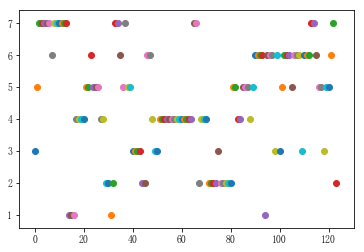

In [22]:
for i in range(len(Max_lag_XY)):
    plt.scatter(i, Max_lag_XY[i], alpha=1)

<IPython.core.display.Javascript object>


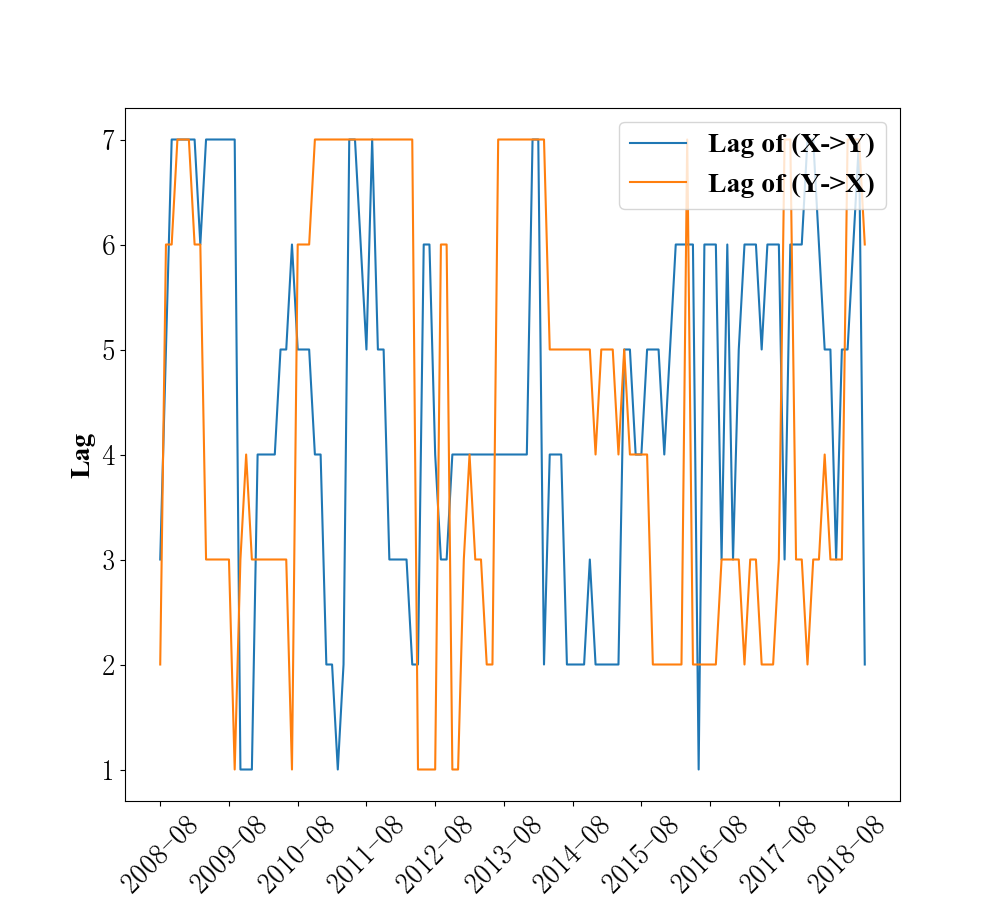

([<matplotlib.axis.XTick at 0x262e9836208>,
 <a list of 11 Text xticklabel objects>)

In [41]:
%matplotlib notebook
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 20,
}
fig = plt.figure(figsize=(10,9))
plt.plot([str(i)[:7] for i in Index], Max_lag_XY, label='Lag of (X->Y)')
plt.plot([str(i)[:7] for i in Index], Max_lag_YX, label='Lag of (Y->X)')
plt.ylabel('Lag',font1)
plt.xlabel('t',font1)
plt.tick_params(labelsize=20)
plt.legend(loc=1,prop=font1)
# plt.grid(alpha=0.3)
plt.xticks([str(i)[:7] for i in Index][::12], rotation=45)

<IPython.core.display.Javascript object>


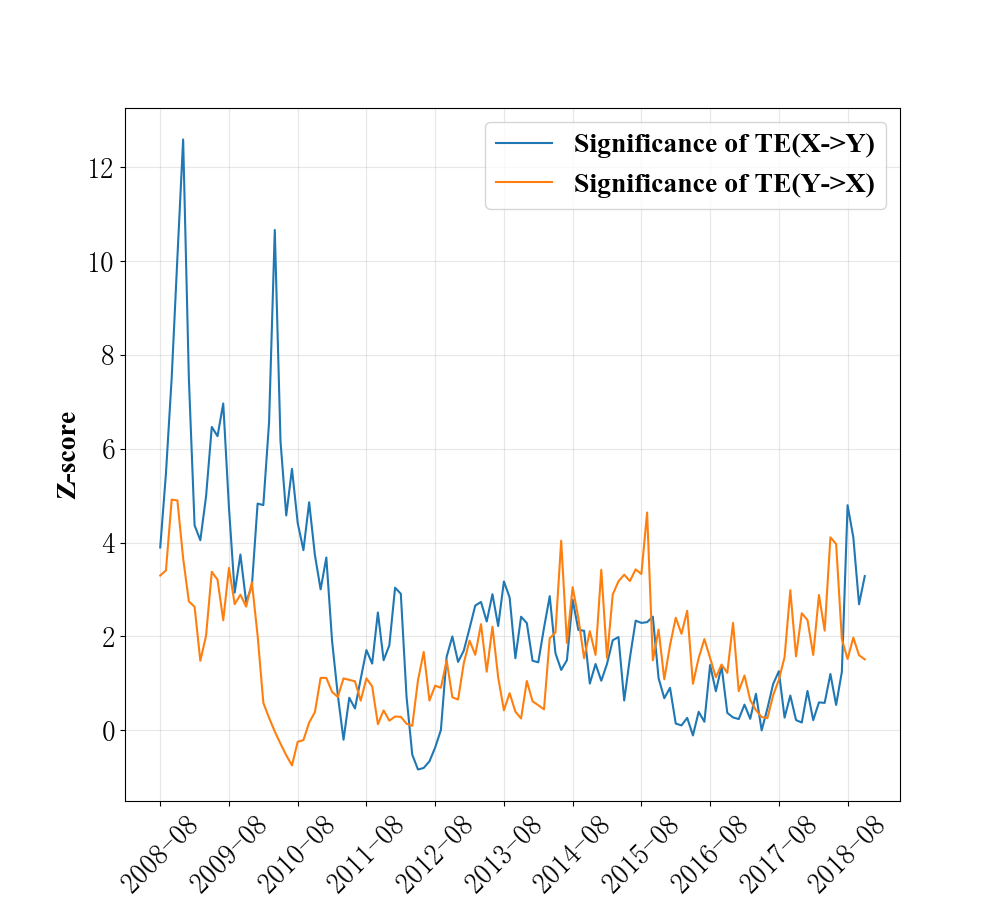

([<matplotlib.axis.XTick at 0x2628382b320>,
 <a list of 11 Text xticklabel objects>)

In [43]:
%matplotlib notebook
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 20,
}
fig = plt.figure(figsize=(10,9))
plt.plot([str(i)[:7] for i in Index], Max_zcore_XY, label='Significance of TE(X->Y)')
plt.plot([str(i)[:7] for i in Index], Max_zcore_YX, label='Significance of TE(Y->X)')
plt.ylabel('Z-score',font1)
plt.xlabel('t',font1)
plt.tick_params(labelsize=20)
plt.legend(loc=1,prop=font1)
plt.grid(alpha=0.3)
plt.xticks([str(i)[:7] for i in Index][::12], rotation=45)

<IPython.core.display.Javascript object>


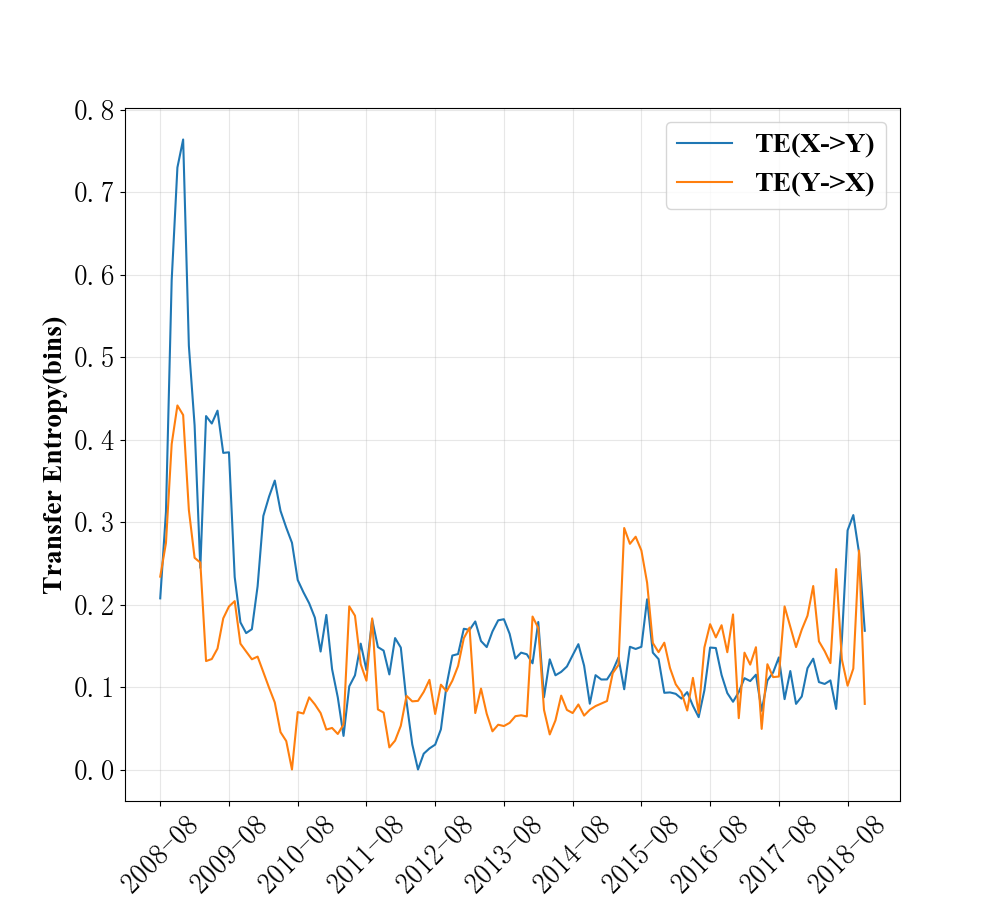

([<matplotlib.axis.XTick at 0x262834ef5f8>,
 <a list of 11 Text xticklabel objects>)

In [45]:
%matplotlib notebook
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 20,
}
fig = plt.figure(figsize=(10,9))
plt.plot([str(i)[:7] for i in Index], Max_TE_XY-np.min(Max_TE_XY), label='TE(X->Y)')
plt.plot([str(i)[:7] for i in Index], Max_TE_YX- np.min(Max_TE_YX), label='TE(Y->X)')
plt.ylabel('Transfer Entropy(bins)',font1)
plt.xlabel('t',font1)
plt.legend(loc=1,prop=font1)
plt.tick_params(labelsize=20)
plt.grid(alpha=0.3)
plt.xticks([str(i)[:7] for i in Index][::12], rotation=45)